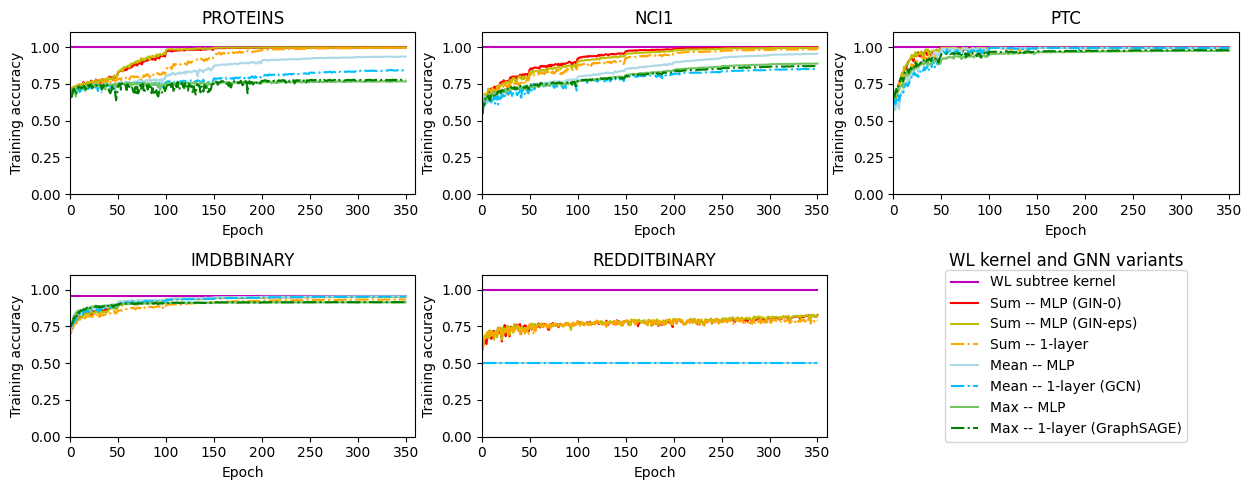

In [9]:
"""
Reproducing training set performance of GINs and other GNN variants
"""
import matplotlib.pyplot as plt
import numpy as np

# Based on https://www.color-meanings.com/shades-of-blue-color-names-html-hex-rgb-codes/
SKY_BLUE = (173/255, 216/255, 230/255)
CAPRI_BLUE = (0, 191/255, 1)

# Based on https://www.colorsexplained.com/shades-of-green-color-names/
MANTIS_GREEN = (116/255, 195/255, 101/255)

EPOCHS = np.array(range(1, 351))
FOLD_INDICES_AMOUNT = 10
TRAINING_ACCURACY_COLUMN_INDEX = 2

SUBPLOTS_TITLES = [['PROTEINS', 'NCI1', 'PTC'], ['IMDBBINARY', 'REDDITBINARY']]
WL_SUBTREE_KERNEL_ACCURACIES = [
    [np.full(350, 1.0), np.full(350, 1.0), np.full(350, 1.0)],
    [np.full(350, 0.953), np.full(350, 1.0)]
]


def plot_data(
    subplot, title, x, y1, y2, y3, y4, y5, y6,
    color1='m', linestyle1='-',
    color2='r', linestyle2='-',
    color3='y', linestyle3='-',
    color4='orange', linestyle4='-.',
    color5=SKY_BLUE, linestyle5='-',
    color6=CAPRI_BLUE, linestyle6='-.',
    **kwargs
):
    """
    Assigning given data and title to a given subplot, where the given data
    represents accuracy of different GNN variants over the same dataset.
    The colors and linestyles given as default arguments mimic as much as
    possible the original colors from the article's graphs.

    :param subplot: The specific subplot to which data is appended
    (matplotlib.axes.Axes)
    :param title: The title of the dataset of which results are plotted (str)
    :param x: The x axis data to be plotted (np.array)
    :params y1,y2,y3,y4,y5,y6: y axis data to be plotted (each is np.array)
    :params color1,color2,color3,color4: Colors of plotted graphs (str)
    :params color5, color6: More colors of plotted graphs (tuple)
    :params linestyle1,linestyle2,linestyle3,linestyle4,linestyle5,
    linestyle6: Linestyles of plotted graphs (str)
    :params kwargs: May contain extra data (+ its attributes) to be plotted
    """
    subplot.plot(x, y1, label='WL subtree kernel', color=color1, linestyle=linestyle1)
    subplot.plot(x, y2, label='Sum -- MLP (GIN-0)', color=color2, linestyle=linestyle2)
    subplot.plot(x, y3, label='Sum -- MLP (GIN-eps)', color=color3, linestyle=linestyle3)
    subplot.plot(x, y4, label='Sum -- 1-layer', color=color4, linestyle=linestyle4)
    subplot.plot(x, y5, label='Mean -- MLP', color=color5, linestyle=linestyle5)
    subplot.plot(x, y6, label='Mean -- 1-layer (GCN)', color=color6, linestyle=linestyle6)

    # Max-mlp and Max-1-layer may not be given as arguments in advance as they
    # do not appear in the REDDITBINARY training accuracy graph. If they do
    # appear, they are plotted with colors and linestyles like in the article
    if 'y7' in kwargs:
        subplot.plot(x, kwargs['y7'], label='Max -- MLP', color=MANTIS_GREEN, linestyle='-')
    if 'y8' in kwargs:
        subplot.plot(x, kwargs['y8'], label='Max -- 1-layer (GraphSAGE)', color='g', linestyle='-.')

    subplot.set_title(title)
    subplot.set_xlabel("Epoch")
    subplot.set_ylabel("Training accuracy")
    subplot.set_ylim([0, 1.1])
    subplot.set_xlim([0, 360])


def get_average_training_accuracy_per_epoch(gnn_variant, title):
    """
    Calculates and returns the average training accuracy across the 10 folds,
    given a GNN variant and a dataset
    :param gnn_variant: The GNN variant, as it appears in the names of the
    output files (str)
    :param title: The title of the dataset of which accuracy is calculated (str)
    :return: The average training accuracy across the 10 folds (np.array)
    """
    accuracies_for_all_fold_indices = []
    for fold_idx in range(FOLD_INDICES_AMOUNT):
        filename = f'outputs/{gnn_variant}_{title}_{fold_idx}'
        accuracies_for_all_fold_indices.append(np.loadtxt(filename)[:, TRAINING_ACCURACY_COLUMN_INDEX])
    return np.mean(np.array(accuracies_for_all_fold_indices), axis=0)


def append_data_to_subplots(subplots):
    """
    For each subplot, extracts the relevant data to be plotted and calls the
    plotting function

    :param subplots: The subplots on which data will be plotted (list of
    matplotlib.pyplot.Axes)
    """
    # Plot data on each subplot of our 2x3 figure (except for bottom-right
    # which is legend)
    for i in range(2):
        for j in range(3):
            if (i, j) != (1, 2):
                title = SUBPLOTS_TITLES[i][j]

                # It was not written explicitly in the article that the value
                # assigned to each epoch in these graphs is the average accuracy
                # across 10 folds. However, using this method (over other
                # methods, like maximum across 10 folds) gave us the closest
                # training accuracy graphs to the original ones in the article
                y2 = get_average_training_accuracy_per_epoch('sum_mlp_0', title)
                y3 = get_average_training_accuracy_per_epoch('sum_mlp_eps', title)
                y4 = get_average_training_accuracy_per_epoch('sum_1_layer', title)
                y5 = get_average_training_accuracy_per_epoch('mean_mlp', title)
                y6 = get_average_training_accuracy_per_epoch('mean_1_layer', title)

                # Notice that REDDITBINARY graph does not contain Max-MLP and
                # Max-1-layer lines
                if title != 'REDDITBINARY':
                    y7 = get_average_training_accuracy_per_epoch('max_mlp', title)
                    y8 = get_average_training_accuracy_per_epoch('max_1_layer', title)
                    plot_data(subplots[i, j], title, EPOCHS, WL_SUBTREE_KERNEL_ACCURACIES[i][j], y2, y3, y4, y5, y6, y7=y7, y8=y8)
                else:
                    plot_data(subplots[i, j], title, EPOCHS, WL_SUBTREE_KERNEL_ACCURACIES[i][j], y2, y3, y4, y5, y6)


def set_plot_layout(subplots):
    """
    Defines more required properties to the figure to mimic the figure in
    the article

    :param subplots: The subplots on which data will be plotted (list of
    matplotlib.pyplot.Axes)
    """
    # Use the bottom right subplot for the legend and hide its axis decorations
    subplots[1, 2].axis('off')
    # Get the handles and labels from one of the plots which contains all eight lines
    handles, labels = subplots[0, 0].get_legend_handles_labels()

    subplots[1, 2].legend(handles, labels, loc='center')
    subplots[1, 2].set_title('WL kernel and GNN variants')


def main():
    # Create a 2x3 grid of subplots
    _, subplots = plt.subplots(2, 3, figsize=(12.5, 5))

    append_data_to_subplots(subplots)
    set_plot_layout(subplots)

    # Display the figure
    plt.tight_layout()
    plt.show()


if __name__ == '__main__':
    main()

In [10]:
"""
Reproducing test set classification accuracies (%)
"""
import numpy as np
import pandas as pd


TEST_ACCURACY_COLUMN_INDEX = 3
FOLD_INDICES_AMOUNT = 10

DATASET_TITLES = ['IMDBBINARY', 'IMDBMULTI', 'REDDITBINARY', 'REDDITMULTI5K',
                  'COLLAB', 'MUTAG', 'PROTEINS', 'PTC', 'NCI1']
OUTPUT_DATAFRAME_ROWS = ['Dataset', 'WL subtree', 'DCNN', 'PATCHYSAN', 'DGCNN',
                     'AWL', 'Sum-MLP (GIN-0)', 'Sum-MLP (GIN-eps)',
                     'Sum-1-layer', 'Mean-MLP', 'Mean-1-layer (GCN)', 'Max-MLP',
                     'Max-1-layer (GraphSAGE)']

# Non-GNN baselines accuracies, based on other articles
WL_SUBTREE_KERNEL_ACCURACIES = {
    'IMDBBINARY': '73.8 ± 3.9',
    'IMDBMULTI': '50.9 ± 3.8',
    'REDDITBINARY': '81.0 ± 3.1',
    'REDDITMULTI5K': '52.5 ± 2.1',
    'COLLAB': '78.9 ± 1.9',
    'MUTAG': '90.4 ± 5.7',
    'PROTEINS': '75.0 ± 3.1',
    'PTC': '59.9 ± 4.3',
    'NCI1': '86.0 ± 1.8'
}
DCNN_ACCURACIES = {
    'IMDBBINARY': '49.1',
    'IMDBMULTI': '33.5',
    'REDDITBINARY': '-',
    'REDDITMULTI5K': '-',
    'COLLAB': '52.1',
    'MUTAG': '67.0',
    'PROTEINS': '61.3',
    'PTC': '56.6',
    'NCI1': '62.6'
}
PATCHYSAN_ACCURACIES = {
    'IMDBBINARY': '71.0 ± 2.2',
    'IMDBMULTI': '45.2 ± 2.8',
    'REDDITBINARY': '86.3 ± 1.6',
    'REDDITMULTI5K': '49.1 ± 0.7',
    'COLLAB': '72.6 ± 2.2',
    'MUTAG': '92.6 ± 4.2',
    'PROTEINS': '75.9 ± 2.8',
    'PTC': '60.0 ± 4.8',
    'NCI1': '78.6 ± 1.9'
}
DGCNN_ACCURACIES = {
    'IMDBBINARY': '70.0',
    'IMDBMULTI': '47.8',
    'REDDITBINARY': '-',
    'REDDITMULTI5K': '-',
    'COLLAB': '73.7',
    'MUTAG': '85.8',
    'PROTEINS': '75.5',
    'PTC': '58.6',
    'NCI1': '74.4'
}
AWL_ACCURACIES = {
    'IMDBBINARY': '74.5 ± 5.9',
    'IMDBMULTI': '51.5 ± 3.6',
    'REDDITBINARY': '87.9 ± 2.5',
    'REDDITMULTI5K': '54.7 ± 2.9',
    'COLLAB': '73.9 ± 1.9',
    'MUTAG': '87.9 ± 9.8',
    'PROTEINS': '-',
    'PTC': '-',
    'NCI1': '-'
}


def get_epoch_data_with_max_accuracy(gnn_variant, title):
    """
    Calculates and returns the epoch's data with the highest average test
    accuracy across the 10 folds, given specific GNN variant and dataset
    :param gnn_variant: The GNN variant, as it appears in the names of the
    output files (str)
    :param title: The title of the dataset of which accuracy is calculated (str)
    :return: The epoch's data with the highest average test accuracy across the
    10 folds (np.array)
    """
    accuracies_for_all_fold_indices = []
    for fold_idx in range(FOLD_INDICES_AMOUNT):
        filename = f'outputs/{gnn_variant}_{title}_{fold_idx}'
        accuracies_for_all_fold_indices.append(np.loadtxt(filename)[:, TEST_ACCURACY_COLUMN_INDEX])

    epoch_with_max_accuracy = np.argmax(np.mean(accuracies_for_all_fold_indices, axis=0))
    epoch_data = (np.array(accuracies_for_all_fold_indices))[:, epoch_with_max_accuracy]

    return epoch_data


def get_data(title):
    """
    Extracts test accuracy data of all GNN variants from the output files,
    given a dataset title

    :param title: The title of the dataset of which accuracy is calculated (str)
    :return: Epoch data with max accuracy for any relevant GNN variant (tuple)
    """
    sum_mlp_0_data = get_epoch_data_with_max_accuracy('sum_mlp_0', title)
    sum_mlp_eps_data = get_epoch_data_with_max_accuracy('sum_mlp_eps', title)
    sum_1_layer_data = get_epoch_data_with_max_accuracy('sum_1_layer', title)
    mean_mlp_data = get_epoch_data_with_max_accuracy('mean_mlp', title)
    mean_1_layer_data = get_epoch_data_with_max_accuracy('mean_1_layer', title)
    current_data = (sum_mlp_0_data, sum_mlp_eps_data, sum_1_layer_data, mean_mlp_data, mean_1_layer_data)

    # For the three datasets below, test accuracy has not been provided in
    # the original article and (has not been calculated by us) for the Max-MLP
    # and Max-1-Layer GNN variants
    if title not in ['REDDITMULTI5K', 'REDDITBINARY', 'COLLAB']:
        max_mlp_data = get_epoch_data_with_max_accuracy('max_mlp', title)
        max_1_layer_data = get_epoch_data_with_max_accuracy('max_1_layer', title)
        return current_data + (max_mlp_data, max_1_layer_data)
    return current_data


def calculate_mean_std(values):
    """
    Returns the mean and standard deviation of a given list of values, in
    percentage

    :param values: The values on which mean and std are calculated (np.array)
    :return: Mean and std, in percentage, of given values (tuple)
    """
    return np.mean(values) * 100, np.std(values) * 100


def get_test_accuracy_results():
    """
    Returns the main skeleton of the final output dataframe - i.e all of the
    test accuracy data and some of the dataframe titles (list)
    """
    results = []

    for title in DATASET_TITLES:
        # Getting test accuracy data of non-GNN baselines
        wl_accuracies = WL_SUBTREE_KERNEL_ACCURACIES[title]
        dcnn_accuracies = DCNN_ACCURACIES[title]
        patchysan_accuracies = PATCHYSAN_ACCURACIES[title]
        dgcnn_accuracies = DGCNN_ACCURACIES[title]
        awl_accuracies = AWL_ACCURACIES[title]

        # Getting test accuracy data of all relevant GNN variants
        data = get_data(title)

        # Putting in list all the required accuracy data, both of non-GNN
        # baselines and of GNN variants. Such separation between datasets is
        # done because of the lack of test accuracy in the article of the
        # max-MLP and max-1-layer variants on the three datasets below
        if title not in ['REDDITMULTI5K', 'REDDITBINARY', 'COLLAB']:
            sum_mlp_0_data, sum_mlp_eps_data, sum_1_layer_data, mean_mlp_data, mean_1_layer_data, max_mlp_data, max_1_layer_data = data
            avg_std_accuracies = [
                wl_accuracies,
                dcnn_accuracies,
                patchysan_accuracies,
                dgcnn_accuracies,
                awl_accuracies,
                f"{calculate_mean_std(sum_mlp_0_data)[0]:.2f} ± {calculate_mean_std(sum_mlp_0_data)[1]:.2f}",
                f"{calculate_mean_std(sum_mlp_eps_data)[0]:.2f} ± {calculate_mean_std(sum_mlp_eps_data)[1]:.2f}",
                f"{calculate_mean_std(sum_1_layer_data)[0]:.2f} ± {calculate_mean_std(sum_1_layer_data)[1]:.2f}",
                f"{calculate_mean_std(mean_mlp_data)[0]:.2f} ± {calculate_mean_std(mean_mlp_data)[1]:.2f}",
                f"{calculate_mean_std(mean_1_layer_data)[0]:.2f} ± {calculate_mean_std(mean_1_layer_data)[1]:.2f}",
                f"{calculate_mean_std(max_mlp_data)[0]:.2f} ± {calculate_mean_std(max_mlp_data)[1]:.2f}",
                f"{calculate_mean_std(max_1_layer_data)[0]:.2f} ± {calculate_mean_std(max_1_layer_data)[1]:.2f}"
            ]
        else:
            sum_mlp_0_data, sum_mlp_eps_data, sum_1_layer_data, mean_mlp_data, mean_1_layer_data = data
            avg_std_accuracies = [
                wl_accuracies,
                dcnn_accuracies,
                patchysan_accuracies,
                dgcnn_accuracies,
                awl_accuracies,
                f"{calculate_mean_std(sum_mlp_0_data)[0]:.2f} ± {calculate_mean_std(sum_mlp_0_data)[1]:.2f}",
                f"{calculate_mean_std(sum_mlp_eps_data)[0]:.2f} ± {calculate_mean_std(sum_mlp_eps_data)[1]:.2f}",
                f"{calculate_mean_std(sum_1_layer_data)[0]:.2f} ± {calculate_mean_std(sum_1_layer_data)[1]:.2f}",
                f"{calculate_mean_std(mean_mlp_data)[0]:.2f} ± {calculate_mean_std(mean_mlp_data)[1]:.2f}",
                f"{calculate_mean_std(mean_1_layer_data)[0]:.2f} ± {calculate_mean_std(mean_1_layer_data)[1]:.2f}",
                '-',
                '-'
            ]
        results.append([title] + avg_std_accuracies)

    return results


def main():
    results = get_test_accuracy_results()

    # Preventing word wrap in the output in order to make it more elegant
    pd.set_option('display.width', 1000)
    pd.set_option('display.max_columns', None)

    df = pd.DataFrame(results, columns=OUTPUT_DATAFRAME_ROWS).transpose()

    # Adding a separting line between the title row and baselines results, and
    # between the baseline results and the GNN variants results
    s = df.to_string().replace('\nWL', '\n'+'_'*152+'\nWL').replace('\nSum-MLP (GIN-0)', '\n'+'_'*152+'\nSum-MLP (GIN-0)')
    print(s)

if __name__ == '__main__':
    main()

                                    0             1             2              3             4             5             6              7             8
Dataset                    IMDBBINARY     IMDBMULTI  REDDITBINARY  REDDITMULTI5K        COLLAB         MUTAG      PROTEINS            PTC          NCI1
________________________________________________________________________________________________________________________________________________________
WL subtree                 73.8 ± 3.9    50.9 ± 3.8    81.0 ± 3.1     52.5 ± 2.1    78.9 ± 1.9    90.4 ± 5.7    75.0 ± 3.1     59.9 ± 4.3    86.0 ± 1.8
DCNN                             49.1          33.5             -              -          52.1          67.0          61.3           56.6          62.6
PATCHYSAN                  71.0 ± 2.2    45.2 ± 2.8    86.3 ± 1.6     49.1 ± 0.7    72.6 ± 2.2    92.6 ± 4.2    75.9 ± 2.8     60.0 ± 4.8    78.6 ± 1.9
DGCNN                            70.0          47.8             -              -       